In [1]:
import os
import pandas as pd
from collections import Counter

import sklearn
from lightgbm import LGBMRegressor, LGBMClassifier
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt

In [2]:
assets = ['AA', 'HDB', 'INDA', 'EPI']

In [3]:
df = pd.read_parquet('./prices/HDB_all.parquet')
df = df[df.marketState == 'REGULAR']
df = df.set_index('regularMarketTime')

In [4]:
df.columns

Index(['symbol', 'quoteType', 'marketState', 'regularMarketChangePercent',
       'regularMarketPrice', 'regularMarketChange', 'regularMarketOpen',
       'regularMarketDayHigh', 'regularMarketDayLow', 'regularMarketVolume',
       'bid', 'ask', 'bidSize', 'askSize', 'fiftyTwoWeekLowChange',
       'fiftyTwoWeekLowChangePercent', 'fiftyTwoWeekHighChange',
       'fiftyTwoWeekHighChangePercent', 'trailingPE', 'priceEpsCurrentYear',
       'fiftyDayAverageChange', 'fiftyDayAverageChangePercent',
       'twoHundredDayAverageChange', 'twoHundredDayAverageChangePercent',
       'marketCap', 'forwardPE', 'priceToBook'],
      dtype='object')

In [5]:
X = df.drop(['symbol', 'marketState', 'quoteType', 'regularMarketChangePercent'], axis=1).shift(1).dropna(how='all', axis=0)
X

,regularMarketPrice,regularMarketChange,regularMarketOpen,regularMarketDayHigh,regularMarketDayLow,regularMarketVolume,bid,ask,bidSize,askSize,...,fiftyTwoWeekHighChangePercent,trailingPE,priceEpsCurrentYear,fiftyDayAverageChange,fiftyDayAverageChangePercent,twoHundredDayAverageChange,twoHundredDayAverageChangePercent,marketCap,forwardPE,priceToBook
regularMarketTime,,,,,,,,,,,,,,,,,,,,,
2024-07-12 09:30:38Z,60.320,-0.040001,60.39,60.890,60.17,3127956.0,60.53,60.94,9.0,10.0,...,-0.155064,18.968554,22.507462,0.768200,0.012900,1.586250,0.027007,1.529739e+11,19.210190,0.100391
2024-07-12 09:31:45Z,60.690,0.369999,60.39,60.810,60.61,65900.0,60.53,60.95,9.0,10.0,...,-0.149881,19.084906,22.645521,1.138199,0.019113,1.956249,0.033307,1.539123e+11,19.328024,0.101007
2024-07-12 09:32:44Z,60.660,0.340000,60.39,60.810,60.61,73788.0,60.53,60.95,9.0,10.0,...,-0.150301,19.075472,22.634327,1.108200,0.018609,1.926251,0.032796,1.538362e+11,19.318470,0.100957
2024-07-12 09:33:33Z,60.660,0.340000,60.39,60.810,60.60,76597.0,60.53,60.95,9.0,10.0,...,-0.150301,19.075472,22.634327,1.108200,0.018609,1.926251,0.032796,1.538362e+11,19.318470,0.100957
2024-07-12 09:34:52Z,60.590,0.270000,60.39,60.810,60.59,81837.0,60.53,60.94,9.0,10.0,...,-0.151282,19.053460,22.608208,1.038200,0.017434,1.856251,0.031605,1.536587e+11,19.296177,0.100841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30 15:54:59Z,60.880,-0.119999,60.68,61.000,60.68,1767756.0,60.82,60.83,9.0,8.0,...,-0.097272,19.265823,22.973585,-0.292999,-0.004790,1.740501,0.029430,1.546224e+11,19.702267,0.097270
2024-08-30 15:56:00Z,60.900,-0.099998,60.68,61.000,60.68,1778014.0,60.82,60.83,13.0,8.0,...,-0.096975,19.272152,22.981133,-0.272999,-0.004463,1.760502,0.029769,1.546732e+11,19.708738,0.097302
2024-08-30 15:56:59Z,60.940,-0.060001,60.68,61.000,60.68,1813293.0,60.82,60.83,13.0,8.0,...,-0.096382,19.284810,22.996225,-0.233002,-0.003809,1.800499,0.030445,1.547748e+11,19.721684,0.097366


In [6]:
y = df[['regularMarketChangePercent']].iloc[1:]*10
y

,regularMarketChangePercent
regularMarketTime,
2024-07-12 09:30:38Z,6.133935
2024-07-12 09:31:45Z,5.636607
2024-07-12 09:32:44Z,5.636607
2024-07-12 09:33:33Z,4.476135
2024-07-12 09:34:52Z,4.227471
...,...
2024-08-30 15:54:59Z,-1.639319
2024-08-30 15:56:00Z,-0.983629
2024-08-30 15:56:59Z,0.081985


In [7]:
pd.concat([X, y], axis=1).corr()['regularMarketChangePercent']

regularMarketPrice                   0.468151
regularMarketChange                  0.996753
regularMarketOpen                    0.239897
regularMarketDayHigh                 0.430764
regularMarketDayLow                  0.308165
regularMarketVolume                 -0.150730
bid                                  0.013980
ask                                  0.027724
bidSize                             -0.012444
askSize                             -0.048051
fiftyTwoWeekLowChange                0.468151
fiftyTwoWeekLowChangePercent         0.468151
fiftyTwoWeekHighChange               0.228072
fiftyTwoWeekHighChangePercent        0.255685
trailingPE                           0.424981
priceEpsCurrentYear                  0.438165
fiftyDayAverageChange                0.427365
fiftyDayAverageChangePercent         0.426944
twoHundredDayAverageChange           0.493699
twoHundredDayAverageChangePercent    0.494357
marketCap                            0.469235
forwardPE                         

In [8]:
split = 8000

In [9]:
lgbr = LGBMRegressor()
lgbr.fit(X[:split], y[:split])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4795
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 23
[LightGBM] [Info] Start training from score 2.309803


C:\Users\shubh\miniconda3\envs\ibstock\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\shubh\miniconda3\envs\ibstock\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


LGBMRegressor()

In [10]:
lgbr.score(X[split:], y[split:])

0.9179280939242085

In [11]:
y[split:].reset_index(drop=True)

,regularMarketChangePercent
0,0.998129
1,0.499065
2,0.748597
3,1.164527
4,1.081328
...,...
3852,-1.639319
3853,-0.983629
3854,0.081985
3855,0.081985


In [12]:
y_pred = pd.Series(lgbr.predict(X[split:]), name='y_pred')
pd.concat([y_pred, y[split:].reset_index(drop=True)], axis=1)

,y_pred,regularMarketChangePercent
0,0.359966,0.998129
1,1.082664,0.499065
2,0.311039,0.748597
3,0.755165,1.164527
4,1.281806,1.081328
...,...,...
3852,-2.385871,-1.639319
3853,-2.018130,-0.983629
3854,-1.281460,0.081985
3855,-0.239271,0.081985


<Axes: >

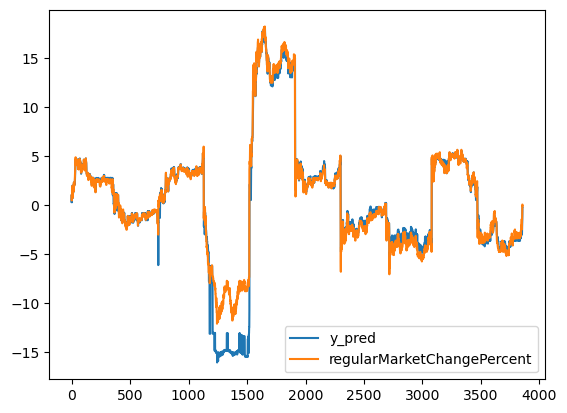

In [13]:
pd.concat([y_pred, y[split:].reset_index(drop=True)], axis=1).plot()

C:\Users\shubh\miniconda3\envs\ibstock\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (390) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65280.756, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55024.963, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24609.565, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=24610.503, Time=1.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=24609.129, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=47442.591, Time=0.91 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=24609.821, Time=0.58 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=24610.771, Time=0.74 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=42022.250, Time=1.53 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=24608.715, Time=2.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=24610.774, Time=4.48 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=24611.882, Time=0.73 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=24610.315, Time=5.16 sec

Best model:  ARIMA(2,0,3

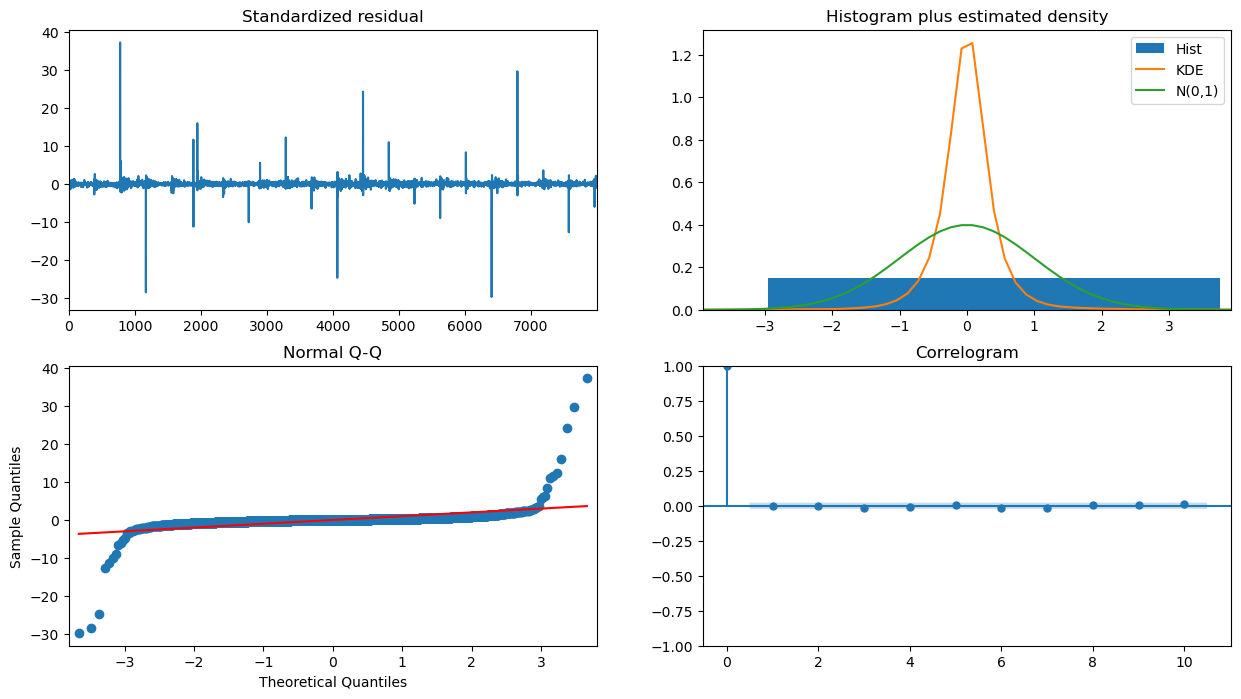

In [14]:
model_autoARIMA = auto_arima(y[:split], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=390,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

C:\Users\shubh\AppData\Local\Temp\ipykernel_7272\2106441882.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  X.index = pd.to_datetime(X.index).to_period('min')
C:\Users\shubh\AppData\Local\Temp\ipykernel_7272\2106441882.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  y.index = pd.to_datetime(y.index).to_period('min')
C:\Users\shubh\miniconda3\envs\ibstock\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shubh\miniconda3\envs\ibstock\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shubh\miniconda3\envs\ibstock\Lib\site-packages\statsmodels\base\model.py:607: Co

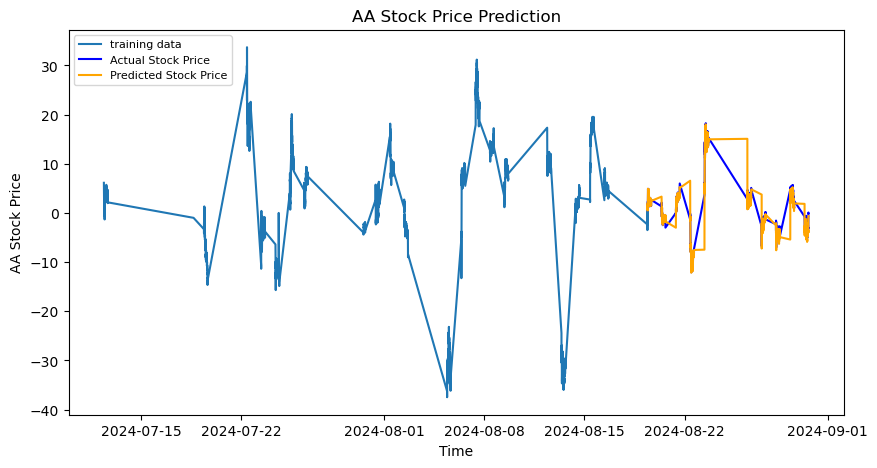

In [15]:
X.index = pd.to_datetime(X.index).to_period('min')
y.index = pd.to_datetime(y.index).to_period('min')
model = SARIMAX(y[:split], order=(2,0,3), exog=X[:split])  
fitted = model.fit()
ff = fitted.get_forecast(len(y[split:]), exog=X[split:])  # 95% conf
fc, se, conf = ff.predicted_mean, ff.se_mean, ff.conf_int()

# Make as pandas series
fc_series = pd.Series(fc.values, index=y[split:].index)
lower_series = pd.Series(conf.iloc[:, 0], index=y[split:].index)
upper_series = pd.Series(conf.iloc[:, 1], index=y[split:].index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
y.index = y.index.to_timestamp()
fc_series.index = fc_series.index.to_timestamp()
plt.plot(y[:split], label='training data')
plt.plot(y[split:], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index.to_timestamp(), lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
pd.concat([fc.reset_index(drop=True), y[split:].reset_index(drop=True)], axis=1).head(50)

,predicted_mean,regularMarketChangePercent
0,0.554931,0.998129
1,1.051952,0.499065
2,0.548530,0.748597
3,0.792842,1.164527
4,1.208537,1.081328
5,1.121015,1.831638
6,1.866199,1.829988
7,1.867810,1.996322
8,2.029483,0.998129
9,1.047002,0.748597


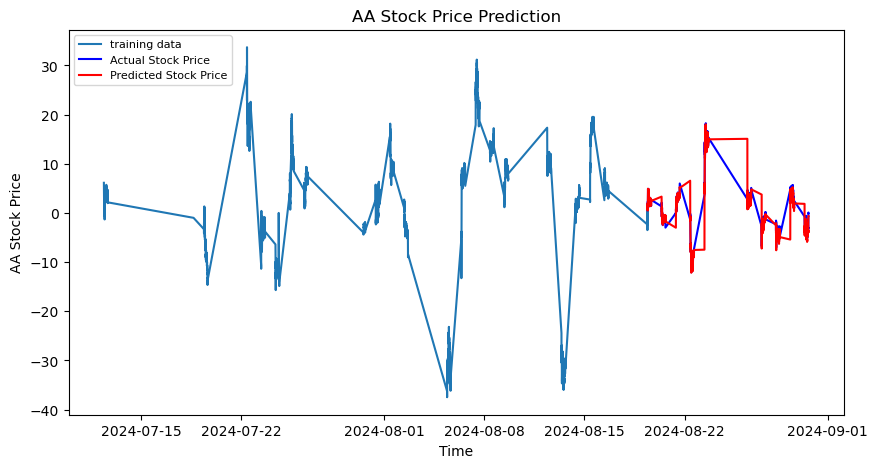

In [17]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(y[:split], label='training data')
plt.plot(y[split:], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index.to_timestamp(), lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()